Device: cuda


C:\Users\akanksh_02\AppData\Local\Temp\ipykernel_11168\443576185.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ms_gwn_a_best.pth",m

MODEL LOADED SUCCESSFULLY


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 163/163 [02:40<00:00,  1.02it/s]



MAE:1.268 RMSE:2.621 MAPE:118.82% R2:0.9077

📍 Center sensor  : 402365
📍 Neighbors      : ['400394', '400922', '400109', '400030']

📋 Actual vs Predicted (mph)

Time    402365_Act 402365_Pred   400394_Act 400394_Pred   400922_Act 400922_Pred   400109_Act 400109_Pred   400030_Act 400030_Pred   
-------------------------------------------------------------------------------------------------------------------------------------
t+1       67.80   66.74   71.60   70.35   66.50   64.98   67.80   67.59   65.90   65.25 
t+2       67.80   66.65   72.80   71.31   66.20   65.31   67.50   67.63   66.50   66.44 
t+3       68.50   67.30   73.80   72.33   66.70   66.30   66.20   66.83   57.90   56.76 
t+4       62.80   62.58   66.10   65.79   60.90   59.99   63.90   63.61   55.00   54.66 
t+5       58.90   57.55   40.60   37.60   40.00   47.41   56.30   56.39   65.20   64.53 
t+6       65.30   67.74   71.60   71.41   66.00   65.51   68.90   67.99   66.90   67.04 
t+7       66.40   65.70   71.90   71

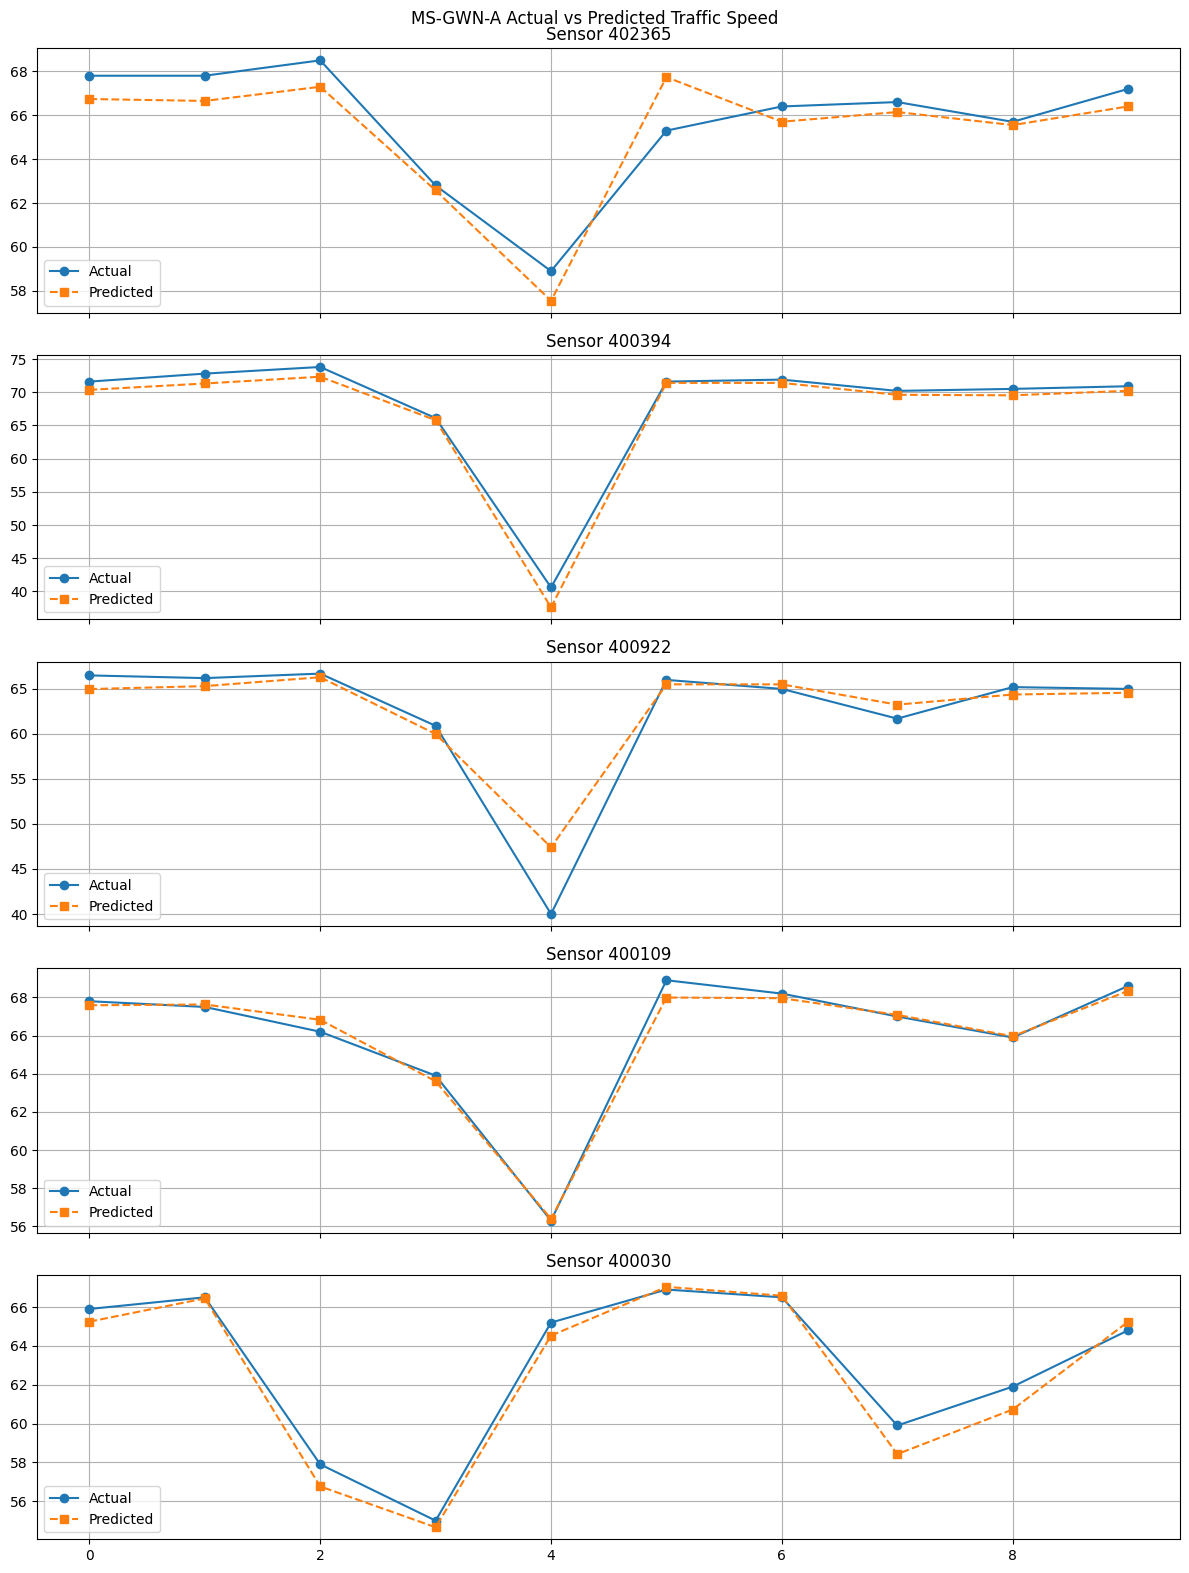


✅ Plot saved: msgwna_actual_vs_predicted.png


In [1]:
# =============================================================
# MS-GWN-A FINAL EVALUATION (CORRECT ARCHITECTURE + PROGRESS BAR)
# =============================================================

import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random, math, os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm

SEED=42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device="cuda" if torch.cuda.is_available() else "cpu"
print("Device:",device)

# =============================================================
# LOAD DATA
# =============================================================
df=pd.read_csv("pems_bay_final_with_extra_features.csv",
               index_col="timestamp",parse_dates=True)

sensor_cols=[c for c in df.columns if c.isdigit()]
time_cols=[c for c in df.columns if c not in sensor_cols]

traffic=df[sensor_cols].to_numpy(dtype=np.float32)
time_feat=df[time_cols].to_numpy(dtype=np.float32)

mean=traffic.mean(0,keepdims=True)
std=traffic.std(0,keepdims=True); std[std==0]=1
traffic=(traffic-mean)/std

# adjacency
with open("adj_mx_PEMS-BAY.pkl","rb") as f:
    adj_data=pickle.load(f,encoding="latin1")
A=adj_data[2].astype(np.float32)
A=A+np.eye(A.shape[0],dtype=np.float32)
D=np.sum(A,axis=1)
D_inv=np.diag(1/np.sqrt(D+1e-8))
A_norm=D_inv@A@D_inv
adj_mx=torch.tensor(A_norm,dtype=torch.float32).to(device)

# combine
T,N=traffic.shape
F_time=time_feat.shape[1]
data=np.concatenate([traffic[...,None],
                     np.broadcast_to(time_feat[:,None,:],(T,N,F_time))],axis=2)

SEQ_LEN=24; PRED_LEN=3; BATCH=64

class TrafficDataset(Dataset):
    def __init__(self,data): self.data=data
    def __len__(self): return len(self.data)-SEQ_LEN-PRED_LEN
    def __getitem__(self,idx):
        x=self.data[idx:idx+SEQ_LEN]
        y=self.data[idx+SEQ_LEN:idx+SEQ_LEN+PRED_LEN,:,0]
        return torch.from_numpy(x).permute(2,1,0), torch.from_numpy(y)

split=int(len(data)*0.8)
test_loader=DataLoader(TrafficDataset(data[split:]),batch_size=BATCH,shuffle=False)

# =============================================================
# EXACT ARCHITECTURE (MATCH CHECKPOINT)
# =============================================================

class NodeAttention(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.query=nn.Linear(channels,channels)
        self.key=nn.Linear(channels,channels)
        self.value=nn.Linear(channels,channels)
        self.scale=math.sqrt(channels)
    def forward(self,x):
        B,C,N,T=x.shape
        x_pool=x.mean(-1).permute(0,2,1)
        Q=self.query(x_pool);K=self.key(x_pool);V=self.value(x_pool)
        attn=torch.softmax(torch.bmm(Q,K.transpose(1,2))/self.scale,dim=-1)
        out=torch.bmm(attn,V).permute(0,2,1)
        return out.unsqueeze(-1).expand(B,C,N,T)

class AdaptiveAdjacency(nn.Module):
    def __init__(self,n,adj_fixed):
        super().__init__()
        self.register_buffer('adj_fixed',adj_fixed)
        self.adj_learned=nn.Parameter(torch.randn(n,n)*0.01)
        self.alpha=nn.Parameter(torch.tensor(0.5))
    def forward(self):
        adj_l=F.relu(self.adj_learned)
        adj_l=adj_l/(adj_l.sum(1,keepdim=True)+1e-8)
        a=torch.sigmoid(self.alpha)
        return a*self.adj_fixed+(1-a)*adj_l

class MultiScaleTemporalBlock(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.conv_1=nn.Conv2d(c,c,(1,3),padding=(0,1))
        self.conv_2=nn.Conv2d(c,c,(1,3),dilation=(1,2),padding=(0,2))
        self.conv_4=nn.Conv2d(c,c,(1,3),dilation=(1,4),padding=(0,4))
        self.fusion=nn.Conv2d(c*3,c,1)
    def forward(self,x):
        return self.fusion(torch.cat([F.relu(self.conv_1(x)),
                                      F.relu(self.conv_2(x)),
                                      F.relu(self.conv_4(x))],1))

class GraphConvolution(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.lin=nn.Linear(c,c)
    def forward(self,x,adj):
        B,C,N,T=x.shape
        x=x.permute(0,3,2,1).reshape(B*T,N,C)
        x=torch.bmm(adj.unsqueeze(0).expand(B*T,N,N),x)
        return self.lin(x).reshape(B,T,N,C).permute(0,3,2,1)

class TemporalAttention(nn.Module):
    def __init__(self,p):
        super().__init__()
        self.attn_weights=nn.Parameter(torch.ones(p)/p)
    def forward(self,x):
        return x*torch.softmax(self.attn_weights,0).view(1,-1,1)

class MS_GWN_A(nn.Module):
    def __init__(self,n,in_dim,out_dim,adj_fixed):
        super().__init__()
        channels=48; num_blocks=3
        self.adaptive_adj=AdaptiveAdjacency(n,adj_fixed)
        self.input_proj=nn.Conv2d(in_dim,channels,1)
        self.temporal_blocks=nn.ModuleList([MultiScaleTemporalBlock(channels) for _ in range(num_blocks)])
        self.graph_convs=nn.ModuleList([GraphConvolution(channels) for _ in range(num_blocks)])
        self.node_attentions=nn.ModuleList([NodeAttention(channels) for _ in range(num_blocks)])
        self.skip_convs=nn.ModuleList([nn.Conv2d(channels,channels,1) for _ in range(num_blocks)])
        self.temporal_pool=nn.AdaptiveAvgPool2d((n,1))
        self.output_proj=nn.Sequential(nn.Linear(channels,128),nn.ReLU(),nn.Dropout(0.1),nn.Linear(128,out_dim))
        self.temporal_attn=TemporalAttention(out_dim)

    def forward(self,x):
        adj=self.adaptive_adj(); x=self.input_proj(x); skips=[]
        for t,g,a,s in zip(self.temporal_blocks,self.graph_convs,self.node_attentions,self.skip_convs):
            r=x; x=t(x); x=F.relu(g(x,adj)); x=x+a(x); x=x+r; skips.append(s(x))
        x=torch.stack(skips).sum(0)
        x=self.temporal_pool(x).squeeze(-1).permute(0,2,1)
        return self.temporal_attn(self.output_proj(x).permute(0,2,1))

# =============================================================
# LOAD MODEL
# =============================================================
model=MS_GWN_A(N,data.shape[2],PRED_LEN,adj_mx).to(device)
model.load_state_dict(torch.load("ms_gwn_a_best.pth",map_location=device))
model.eval()
print("MODEL LOADED SUCCESSFULLY")

# =============================================================
# METRICS WITH PROGRESS BAR
# =============================================================
mae=mse=mape=count=0
preds=[]; trues=[]

for x,y in tqdm(test_loader,desc="Evaluating"):
    x,y=x.to(device),y.to(device)
    with torch.no_grad():
        pred=model(x)

    mae+=torch.abs(pred-y).sum().item()
    mse+=((pred-y)**2).sum().item()
    mask=y!=0
    mape+=(torch.abs((pred-y)/(y+1e-8))[mask]).sum().item()
    count+=y.numel()

    preds.append(pred.cpu().numpy())
    trues.append(y.cpu().numpy())

mae/=count; rmse=(mse/count)**0.5; mape=(mape/count)*100
real_mae=mae*std.mean(); real_rmse=rmse*std.mean()
r2=r2_score(np.concatenate(trues).reshape(-1),np.concatenate(preds).reshape(-1))

print(f"\nMAE:{real_mae:.3f} RMSE:{real_rmse:.3f} MAPE:{mape:.2f}% R2:{r2:.4f}")



# =============================================================
# SELECT 5 CONNECTED SENSORS
# =============================================================
degree = A_norm.sum(axis=1)
center = int(np.argmax(degree))
neighbors = list(np.argsort(A_norm[center])[::-1][1:5])
sensor_ids = [center] + neighbors

print(f"\n📍 Center sensor  : {sensor_cols[center]}")
print(f"📍 Neighbors      : {[sensor_cols[i] for i in neighbors]}")


# =============================================================
# COLLECT 10 TIMESTEPS
# =============================================================
TIMESTEPS = 10
actuals = []
predicted = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= TIMESTEPS:
            break

        x = x.to(device)
        pred = model(x)

        # first sample, first horizon
        act_real  = y[0, 0, :].cpu().numpy() * std[0] + mean[0]
        pred_real = pred[0, 0, :].cpu().numpy() * std[0] + mean[0]

        actuals.append(act_real)
        predicted.append(pred_real)

actuals = np.array(actuals)
predicted = np.array(predicted)


# =============================================================
# PRINT TABLE
# =============================================================
sensor_names = [sensor_cols[i] for i in sensor_ids]
timesteps = [f"t+{i+1}" for i in range(TIMESTEPS)]

print("\n📋 Actual vs Predicted (mph)\n")

header = f"{'Time':<8}"
for s in sensor_names:
    header += f"{s}_Act {s}_Pred   "
print(header)
print("-"*len(header))

for t in range(TIMESTEPS):
    row = f"{timesteps[t]:<8}"
    for s in sensor_ids:
        row += f"{actuals[t,s]:7.2f} {predicted[t,s]:7.2f} "
    print(row)


# =============================================================
# PLOT GRAPH
# =============================================================
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True)
fig.suptitle("MS-GWN-A Actual vs Predicted Traffic Speed")

for i, (s_idx, s_name) in enumerate(zip(sensor_ids, sensor_names)):
    axes[i].plot(actuals[:, s_idx], marker='o', label='Actual')
    axes[i].plot(predicted[:, s_idx], marker='s', linestyle='--', label='Predicted')
    axes[i].set_title(f"Sensor {s_name}")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.savefig("msgwna_actual_vs_predicted.png", dpi=150)
plt.show()

print("\n✅ Plot saved: msgwna_actual_vs_predicted.png")


In [24]:
import numpy as np
import pickle

file_path = "adj_mx_PEMS-BAY.pkl"   # <-- correct file

with open(file_path, "rb") as f:
    adj_data = pickle.load(f, encoding="latin1")

# PeMS-BAY structure
adj_matrix = adj_data[2].astype(np.float32)

print("Shape:", adj_matrix.shape)
print("Number of nodes:", adj_matrix.shape[0])
print("Number of edges:", np.count_nonzero(adj_matrix))
print("Density:", np.count_nonzero(adj_matrix)/adj_matrix.size)

print("\nFirst 10x10 block:")
print(adj_matrix[:10,:10])

# WARNING: full matrix is huge (325x325)
# print(adj_matrix)


Shape: (325, 325)
Number of nodes: 325
Number of edges: 2694
Density: 0.02550532544378698

First 10x10 block:
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.13655277 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.6148081  0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.23919003 0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.        

In [26]:
"""
Extract and save normalization parameters (mean/std) from training data
Run this ONCE to generate train_mean.npy and train_std.npy
"""

import numpy as np
import pandas as pd

# Load CSV
csv_path = "pems_bay_final_with_extra_features.csv"
df = pd.read_csv(csv_path, index_col="timestamp", parse_dates=True, low_memory=False)

# Get sensor columns
sensor_cols = [c for c in df.columns if c.isdigit()]

# Get traffic data
traffic = df[sensor_cols].to_numpy(dtype=np.float32)

# Calculate mean and std (EXACTLY as in training)
mean = traffic.mean(axis=0, keepdims=True)  # shape: (1, N)
std = traffic.std(axis=0, keepdims=True)    # shape: (1, N)
std[std == 0] = 1.0

# Save
np.save("train_mean.npy", mean)
np.save("train_std.npy", std)

print("✓ Saved train_mean.npy")
print("✓ Saved train_std.npy")
print(f"  Mean shape: {mean.shape}")
print(f"  Std shape: {std.shape}")
print(f"  Sample mean for sensor 0: {mean[0, 0]:.3f}")
print(f"  Sample std for sensor 0: {std[0, 0]:.3f}")

✓ Saved train_mean.npy
✓ Saved train_std.npy
  Mean shape: (1, 325)
  Std shape: (1, 325)
  Sample mean for sensor 0: 67.569
  Sample std for sensor 0: 8.119


In [7]:

import pandas as pd
import numpy as np

df = pd.read_csv('pems_bay_final_with_extra_features.csv', index_col='timestamp', parse_dates=True)
sensor_cols = [c for c in df.columns if c.isdigit()]
traffic = df[sensor_cols].to_numpy(dtype=np.float32)

mean = traffic.mean(axis=0, keepdims=True)
std = traffic.std(axis=0, keepdims=True)
std[std == 0] = 1.0

np.save('train_mean.npy', mean)
np.save('train_std.npy', std)

print('✅ Saved train_mean.npy and train_std.npy')


✅ Saved train_mean.npy and train_std.npy


Total sensors: 325
Nodes: 318
Edges: 1186
Saved: pems_bay_sensor_graph.png
Saved: pems_bay_sensor_graph.pdf


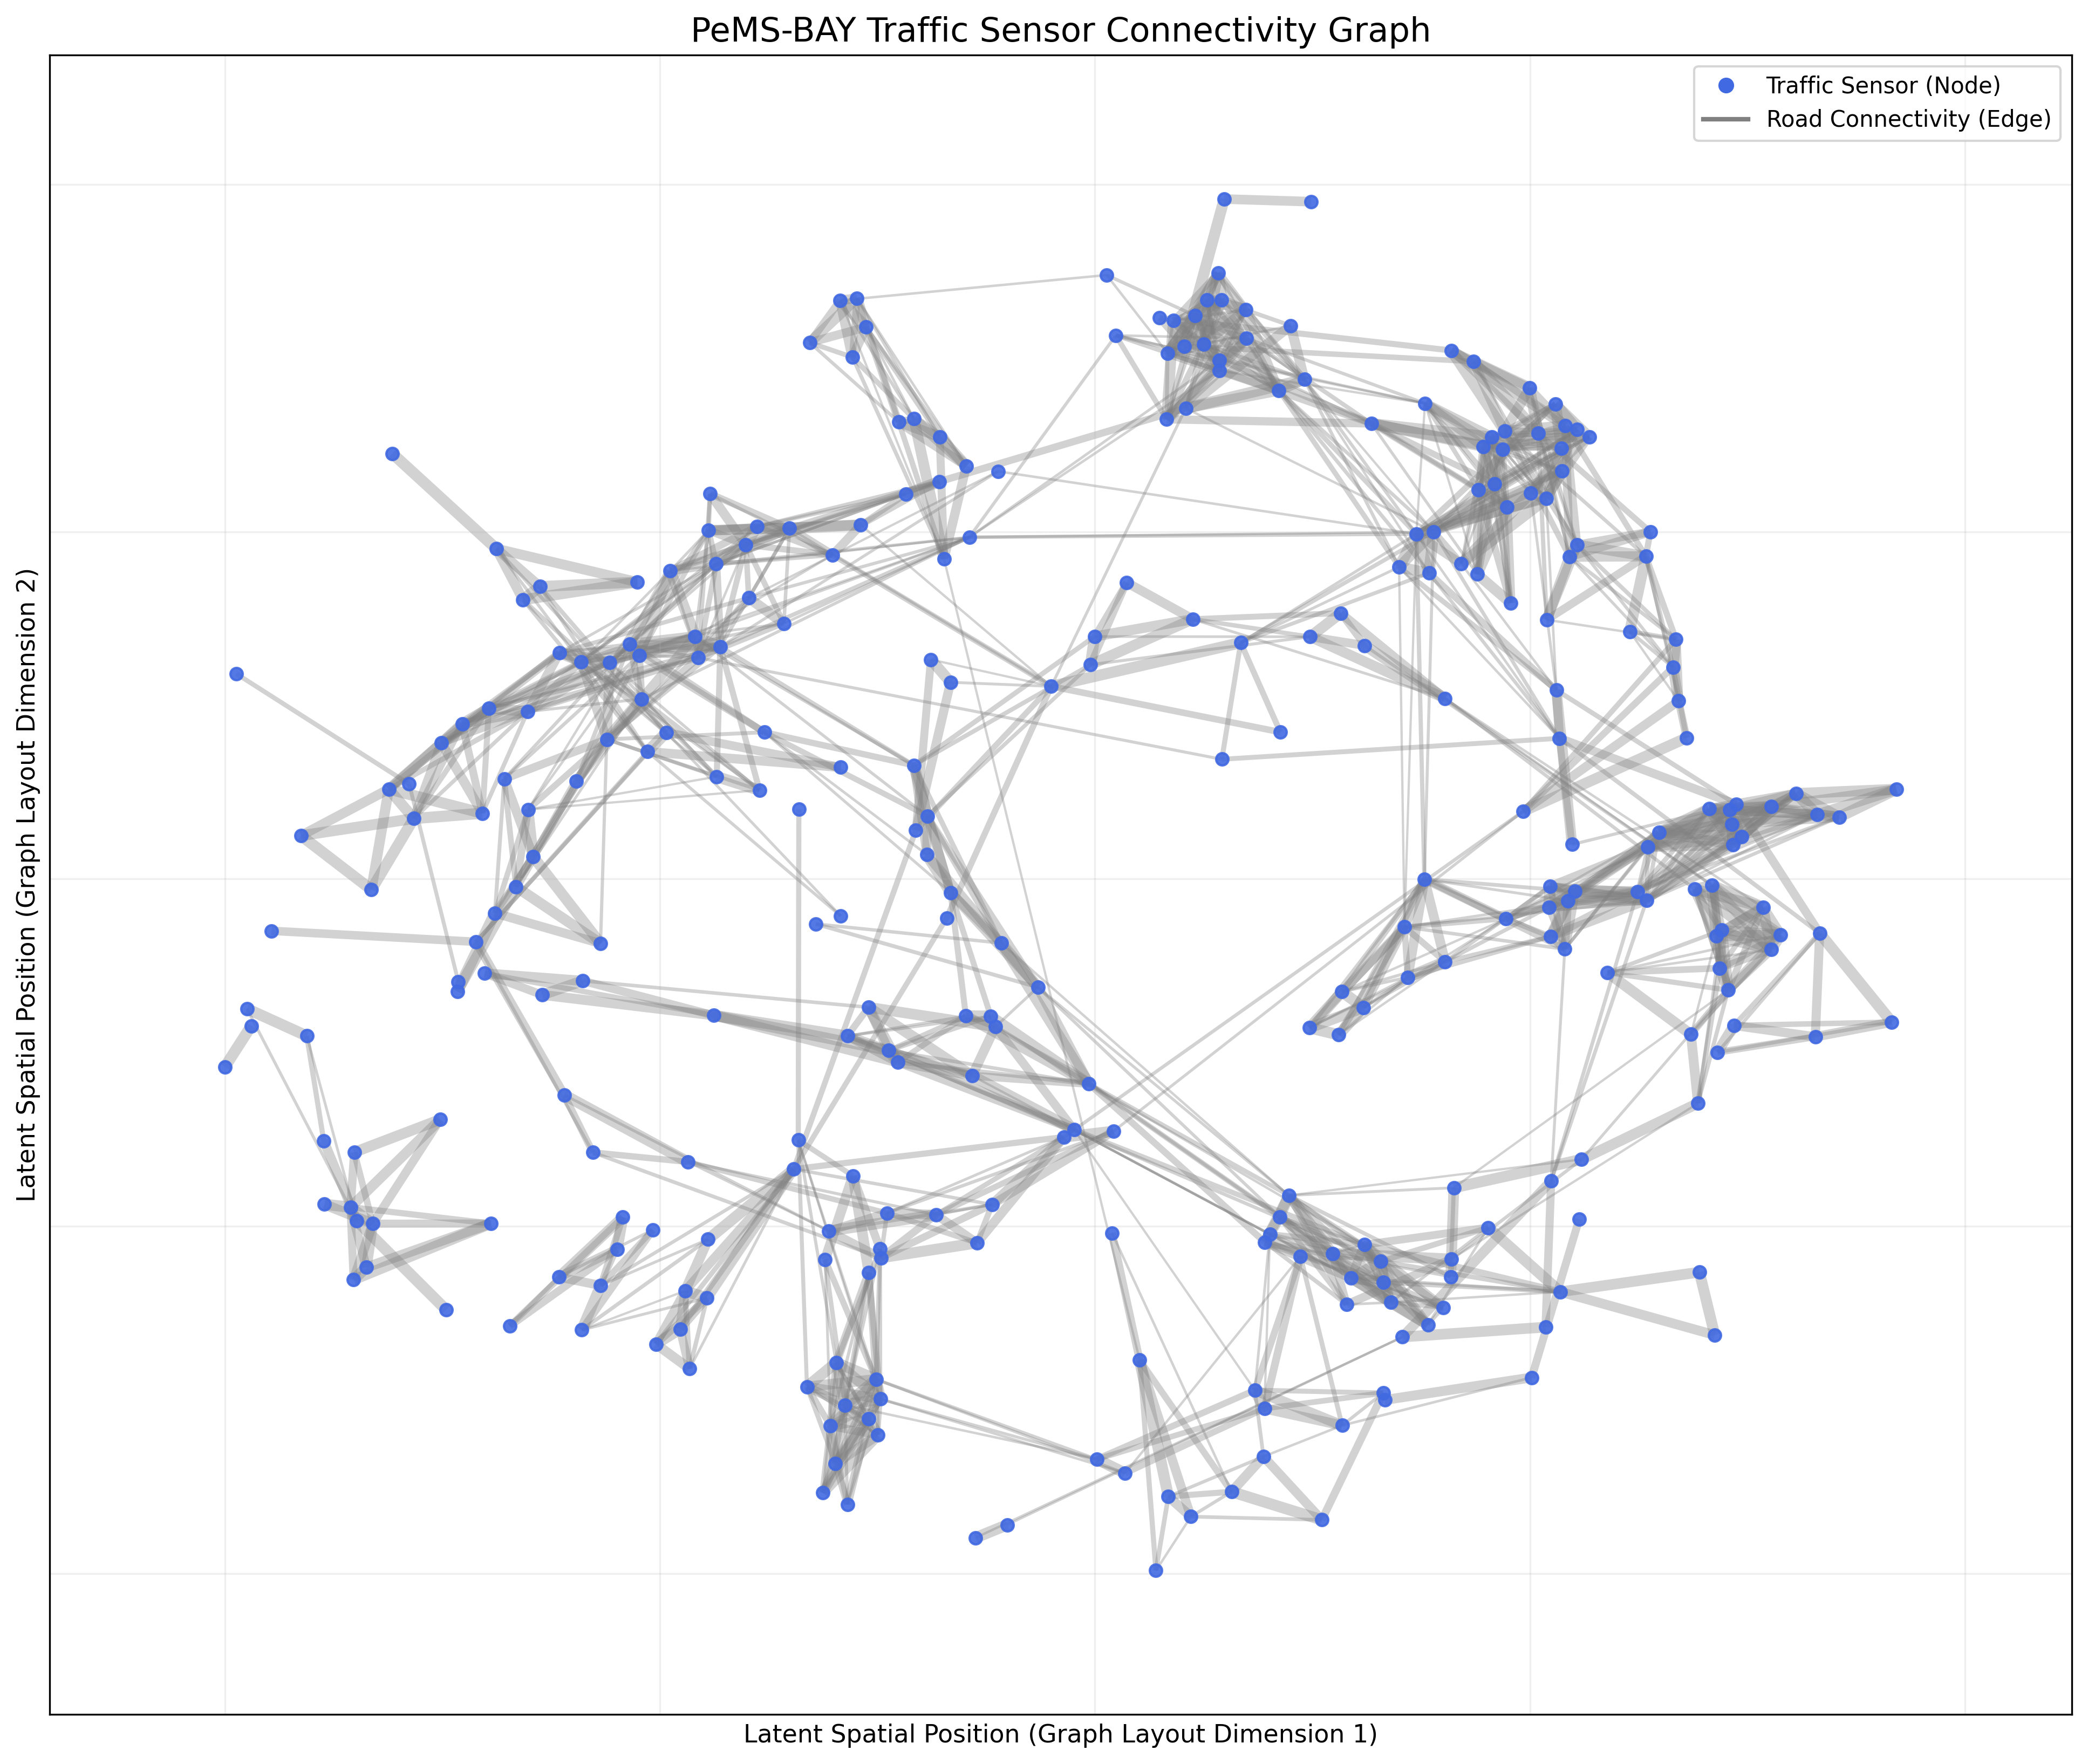

In [21]:
# ============================================================
# 🚦 PEMS-BAY SENSOR CONNECTIVITY GRAPH VISUALIZATION
# High Quality Save Enabled
# ============================================================

import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

FILE = "adj_mx_PEMS-BAY.pkl"

# ------------------------------------------------------------
# LOAD PEMS-BAY GRAPH
# ------------------------------------------------------------
with open(FILE, "rb") as f:
    sensor_ids, sensor_id_to_ind, adj = pickle.load(f, encoding="latin1")

adj = adj.astype(np.float32)

print("Total sensors:", len(sensor_ids))

# ------------------------------------------------------------
# BUILD GRAPH (remove weak connections)
# ------------------------------------------------------------
G = nx.Graph()
THRESHOLD = 0.1   # keep only meaningful road relations

for i in range(len(sensor_ids)):
    for j in range(i+1, len(sensor_ids)):
        weight = adj[i, j]
        if weight > THRESHOLD:
            G.add_edge(sensor_ids[i], sensor_ids[j], weight=weight)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# ------------------------------------------------------------
# GRAPH LAYOUT (NOT GEOGRAPHIC — CONNECTIVITY BASED)
# ------------------------------------------------------------
pos = nx.spring_layout(G, seed=42, k=0.15)

# ------------------------------------------------------------
# EDGE STRENGTH → LINE WIDTH
# ------------------------------------------------------------
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]

min_w, max_w = min(weights), max(weights)
edge_widths = [1 + 4*(w-min_w)/(max_w-min_w+1e-6) for w in weights]

# ------------------------------------------------------------
# DRAW GRAPH USING FIGURE OBJECT
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13,11), dpi=300)

# nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=30,
    node_color="royalblue",
    alpha=0.9,
    ax=ax
)

# edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.35,
    edge_color="gray",
    ax=ax
)

# ------------------------------------------------------------
# LABELS
# ------------------------------------------------------------
ax.set_title("PeMS-BAY Traffic Sensor Connectivity Graph", fontsize=15)
ax.set_xlabel("Latent Spatial Position (Graph Layout Dimension 1)", fontsize=11)
ax.set_ylabel("Latent Spatial Position (Graph Layout Dimension 2)", fontsize=11)
ax.grid(alpha=0.2)

# ------------------------------------------------------------
# LEGEND
# ------------------------------------------------------------
legend_elements = [
    Line2D([0],[0], marker='o', color='w',
           label='Traffic Sensor (Node)',
           markerfacecolor='royalblue', markersize=8),

    Line2D([0],[0], color='gray', lw=2,
           label='Road Connectivity (Edge)')
]

ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()

# ------------------------------------------------------------
# SAVE HIGH QUALITY IMAGE
# ------------------------------------------------------------
png_file = "pems_bay_sensor_graph.png"
pdf_file = "pems_bay_sensor_graph.pdf"

fig.savefig(png_file, dpi=600, bbox_inches='tight')
fig.savefig(pdf_file, bbox_inches='tight')

print("Saved:", png_file)
print("Saved:", pdf_file)

# ------------------------------------------------------------
# DISPLAY
# ------------------------------------------------------------
plt.show()


Device: cuda


C:\Users\akanksh_02\AppData\Local\Temp\ipykernel_9464\254372275.py:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ms_gwn_a_best.pth",ma

MODEL LOADED SUCCESSFULLY


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 163/163 [00:34<00:00,  4.74it/s]



MAE:1.268 RMSE:2.621 MAPE:118.82% R2:0.9077

📍 Center sensor  : 402365
📍 Neighbors      : ['400394', '400922', '400109', '400030']


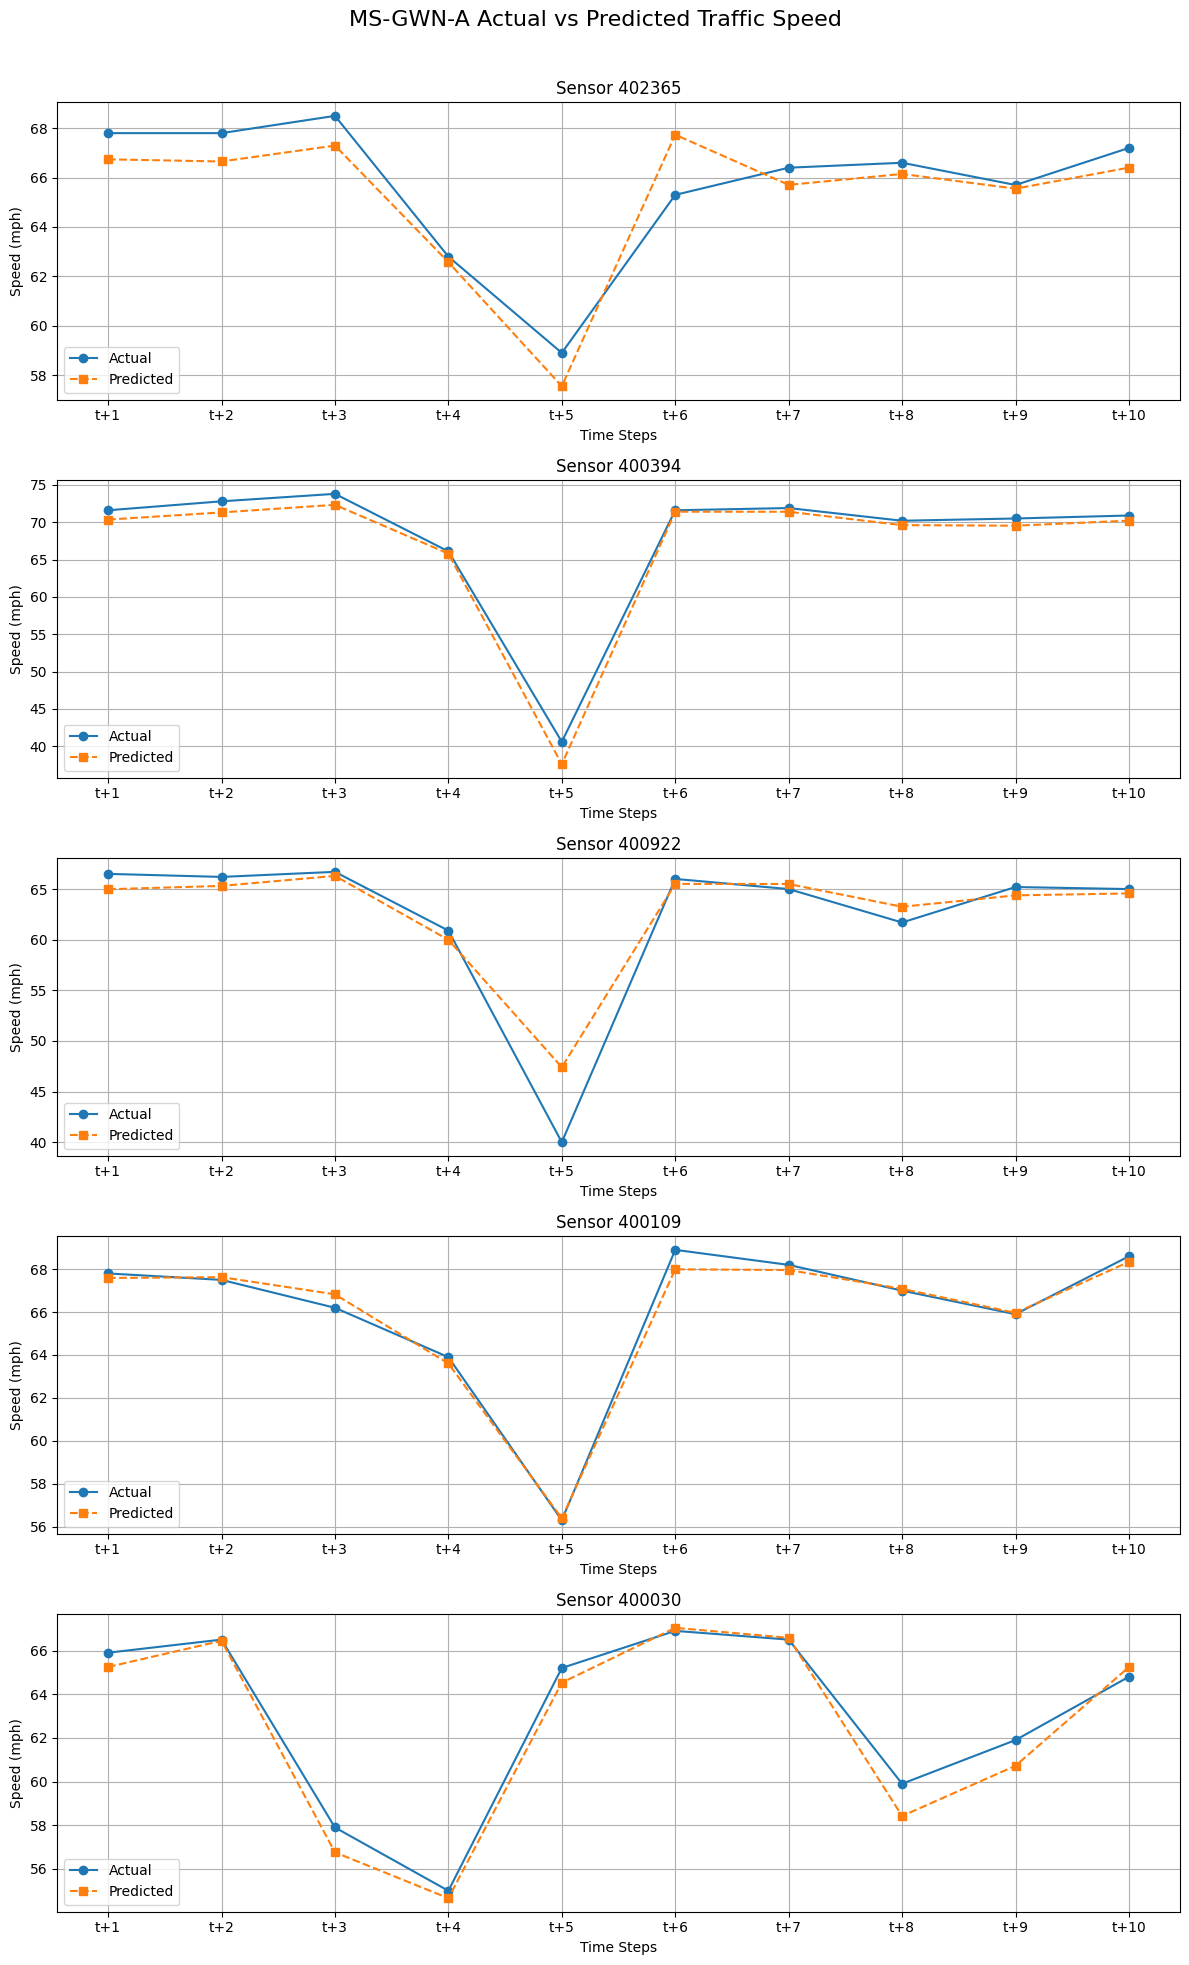


✅ Plot saved: msgwna_actual_vs_predicted.png


In [3]:
# =============================================================
# 🚦 MS-GWN-A FINAL EVALUATION (FULL SINGLE FILE - FIXED PLOTS)
# =============================================================

import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random, math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm

# =============================================================
# SEED + DEVICE
# =============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# =============================================================
# LOAD DATA
# =============================================================
df = pd.read_csv(
    "pems_bay_final_with_extra_features.csv",
    index_col="timestamp",
    parse_dates=True
)

sensor_cols = [c for c in df.columns if c.isdigit()]
time_cols = [c for c in df.columns if c not in sensor_cols]

traffic = df[sensor_cols].to_numpy(dtype=np.float32)
time_feat = df[time_cols].to_numpy(dtype=np.float32)

# Normalize
mean = traffic.mean(0, keepdims=True)
std = traffic.std(0, keepdims=True)
std[std == 0] = 1
traffic = (traffic - mean) / std

# =============================================================
# LOAD ADJACENCY
# =============================================================
with open("adj_mx_PEMS-BAY.pkl", "rb") as f:
    adj_data = pickle.load(f, encoding="latin1")

A = adj_data[2].astype(np.float32)
A = A + np.eye(A.shape[0], dtype=np.float32)
D = np.sum(A, axis=1)
D_inv = np.diag(1 / np.sqrt(D + 1e-8))
A_norm = D_inv @ A @ D_inv
adj_mx = torch.tensor(A_norm, dtype=torch.float32).to(device)

# =============================================================
# COMBINE FEATURES
# =============================================================
T, N = traffic.shape
F_time = time_feat.shape[1]

data = np.concatenate(
    [traffic[..., None],
     np.broadcast_to(time_feat[:, None, :], (T, N, F_time))],
    axis=2
)

SEQ_LEN = 24
PRED_LEN = 3
BATCH = 64

# =============================================================
# DATASET
# =============================================================
class TrafficDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data) - SEQ_LEN - PRED_LEN

    def __getitem__(self, idx):
        x = self.data[idx:idx+SEQ_LEN]
        y = self.data[idx+SEQ_LEN:idx+SEQ_LEN+PRED_LEN,:,0]
        return torch.from_numpy(x).permute(2,1,0), torch.from_numpy(y)

split = int(len(data)*0.8)
test_loader = DataLoader(
    TrafficDataset(data[split:]),
    batch_size=BATCH,
    shuffle=False
)

# =============================================================
# MODEL ARCHITECTURE
# =============================================================

class NodeAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Linear(channels, channels)
        self.key   = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.scale = math.sqrt(channels)

    def forward(self, x):
        B,C,N,T = x.shape
        x_pool = x.mean(-1).permute(0,2,1)
        Q,K,V = self.query(x_pool), self.key(x_pool), self.value(x_pool)
        attn = torch.softmax(torch.bmm(Q,K.transpose(1,2))/self.scale, dim=-1)
        out = torch.bmm(attn,V).permute(0,2,1)
        return out.unsqueeze(-1).expand(B,C,N,T)

class AdaptiveAdjacency(nn.Module):
    def __init__(self, n, adj_fixed):
        super().__init__()
        self.register_buffer('adj_fixed', adj_fixed)
        self.adj_learned = nn.Parameter(torch.randn(n,n)*0.01)
        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self):
        adj_l = F.relu(self.adj_learned)
        adj_l = adj_l/(adj_l.sum(1,keepdim=True)+1e-8)
        a = torch.sigmoid(self.alpha)
        return a*self.adj_fixed + (1-a)*adj_l

class MultiScaleTemporalBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv_1 = nn.Conv2d(c,c,(1,3),padding=(0,1))
        self.conv_2 = nn.Conv2d(c,c,(1,3),dilation=(1,2),padding=(0,2))
        self.conv_4 = nn.Conv2d(c,c,(1,3),dilation=(1,4),padding=(0,4))
        self.fusion = nn.Conv2d(c*3,c,1)

    def forward(self,x):
        return self.fusion(torch.cat([
            F.relu(self.conv_1(x)),
            F.relu(self.conv_2(x)),
            F.relu(self.conv_4(x))
        ],1))

class GraphConvolution(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.lin = nn.Linear(c,c)

    def forward(self,x,adj):
        B,C,N,T = x.shape
        x = x.permute(0,3,2,1).reshape(B*T,N,C)
        x = torch.bmm(adj.unsqueeze(0).expand(B*T,N,N),x)
        return self.lin(x).reshape(B,T,N,C).permute(0,3,2,1)

class TemporalAttention(nn.Module):
    def __init__(self,p):
        super().__init__()
        self.attn_weights = nn.Parameter(torch.ones(p)/p)

    def forward(self,x):
        return x*torch.softmax(self.attn_weights,0).view(1,-1,1)

class MS_GWN_A(nn.Module):
    def __init__(self,n,in_dim,out_dim,adj_fixed):
        super().__init__()
        channels = 48
        num_blocks = 3
        self.adaptive_adj = AdaptiveAdjacency(n,adj_fixed)
        self.input_proj = nn.Conv2d(in_dim,channels,1)
        self.temporal_blocks = nn.ModuleList([MultiScaleTemporalBlock(channels) for _ in range(num_blocks)])
        self.graph_convs = nn.ModuleList([GraphConvolution(channels) for _ in range(num_blocks)])
        self.node_attentions = nn.ModuleList([NodeAttention(channels) for _ in range(num_blocks)])
        self.skip_convs = nn.ModuleList([nn.Conv2d(channels,channels,1) for _ in range(num_blocks)])
        self.temporal_pool = nn.AdaptiveAvgPool2d((n,1))
        self.output_proj = nn.Sequential(
            nn.Linear(channels,128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128,out_dim)
        )
        self.temporal_attn = TemporalAttention(out_dim)

    def forward(self,x):
        adj = self.adaptive_adj()
        x = self.input_proj(x)
        skips = []
        for t,g,a,s in zip(self.temporal_blocks,self.graph_convs,self.node_attentions,self.skip_convs):
            r = x
            x = t(x)
            x = F.relu(g(x,adj))
            x = x + a(x)
            x = x + r
            skips.append(s(x))
        x = torch.stack(skips).sum(0)
        x = self.temporal_pool(x).squeeze(-1).permute(0,2,1)
        return self.temporal_attn(self.output_proj(x).permute(0,2,1))

# =============================================================
# LOAD MODEL
# =============================================================
model = MS_GWN_A(N,data.shape[2],PRED_LEN,adj_mx).to(device)
model.load_state_dict(torch.load("ms_gwn_a_best.pth",map_location=device))
model.eval()
print("MODEL LOADED SUCCESSFULLY")

# =============================================================
# EVALUATION
# =============================================================
mae=mse=mape=count=0
preds=[]; trues=[]

for x,y in tqdm(test_loader,desc="Evaluating"):
    x,y=x.to(device),y.to(device)
    with torch.no_grad():
        pred=model(x)

    mae+=torch.abs(pred-y).sum().item()
    mse+=((pred-y)**2).sum().item()
    mask=y!=0
    mape+=(torch.abs((pred-y)/(y+1e-8))[mask]).sum().item()
    count+=y.numel()

    preds.append(pred.cpu().numpy())
    trues.append(y.cpu().numpy())

mae/=count
rmse=(mse/count)**0.5
mape=(mape/count)*100
real_mae=mae*std.mean()
real_rmse=rmse*std.mean()
r2=r2_score(np.concatenate(trues).reshape(-1),np.concatenate(preds).reshape(-1))

print(f"\nMAE:{real_mae:.3f} RMSE:{real_rmse:.3f} MAPE:{mape:.2f}% R2:{r2:.4f}")

# =============================================================
# SENSOR SELECTION
# =============================================================
degree = A_norm.sum(axis=1)
center = int(np.argmax(degree))
neighbors = list(np.argsort(A_norm[center])[::-1][1:5])
sensor_ids = [center] + neighbors
sensor_names = [sensor_cols[i] for i in sensor_ids]

print(f"\n📍 Center sensor  : {sensor_cols[center]}")
print(f"📍 Neighbors      : {[sensor_cols[i] for i in neighbors]}")

# =============================================================
# COLLECT TIMESTEPS
# =============================================================
TIMESTEPS = 10
actuals=[]
predicted=[]

with torch.no_grad():
    for i,(x,y) in enumerate(test_loader):
        if i>=TIMESTEPS:
            break
        x=x.to(device)
        pred=model(x)
        act_real=y[0,0,:].cpu().numpy()*std[0]+mean[0]
        pred_real=pred[0,0,:].cpu().numpy()*std[0]+mean[0]
        actuals.append(act_real)
        predicted.append(pred_real)

actuals=np.array(actuals)
predicted=np.array(predicted)

# =============================================================
# PLOT (FIXED AXES)
# =============================================================
num_plots=len(sensor_ids)
fig,axes=plt.subplots(num_plots,1,figsize=(12,4*num_plots))

if num_plots==1:
    axes=[axes]

fig.suptitle("MS-GWN-A Actual vs Predicted Traffic Speed",fontsize=16)

x_vals=list(range(TIMESTEPS))
x_labels=[f"t+{i+1}" for i in range(TIMESTEPS)]

for i,(s_idx,s_name) in enumerate(zip(sensor_ids,sensor_names)):
    axes[i].plot(x_vals,actuals[:,s_idx],marker='o',label='Actual')
    axes[i].plot(x_vals,predicted[:,s_idx],marker='s',linestyle='--',label='Predicted')
    axes[i].set_title(f"Sensor {s_name}")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Speed (mph)")
    axes[i].set_xticks(x_vals)
    axes[i].set_xticklabels(x_labels)
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout(rect=[0,0,1,0.97])
plt.savefig("msgwna_actual_vs_predicted.png",dpi=150)
plt.show()

print("\n✅ Plot saved: msgwna_actual_vs_predicted.png")
